In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import jax.numpy as jnp
import jax
import equinox as eqx

from tqdm import tqdm
import typing as tp
import pandas as pd

import sys
sys.path.append("/home/korolevki/mcmc-control-variates/diffcv")

import optax

sns.set_style("darkgrid")

In [3]:
exp_results = pd.DataFrame()

## Experiment Params

In [4]:
DIST_DIM = 2 # Dimension of a Gaussian
N_CHAINS = 10 # Number of parallel chains for MCMC estimates
MCMC_N_RUNS = 1000 # Number of MCMC estimates to calculate CI
INIT_STD = 100 # std of starter points for MC
BATCH_SIZE = 1024 # Batch size for CV training

## Gaussian Mixture

In [5]:
from dist import GaussianMixture

#mixture = GaussianMixture(jnp.vstack([-10*jnp.ones((DIST_DIM), dtype=float), jnp.zeros((DIST_DIM), dtype=float), 10*jnp.ones((DIST_DIM), dtype=float)]), jnp.ones((3), dtype=float))
#mixture = GaussianMixture(jnp.vstack([-10*jnp.ones((DIST_DIM), dtype=float), jnp.zeros((DIST_DIM), dtype=float), 10*jnp.ones((DIST_DIM), dtype=float)]), jnp.ones((3), dtype=float))
mixture = GaussianMixture(jnp.vstack([10 * jnp.ones((DIST_DIM), dtype=float)]), jnp.ones((1), dtype=float))
grad_log_p = jax.jit(jax.grad(mixture.log_p))

2024-07-31 10:11:31.426096: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [6]:
rng = jax.random.PRNGKey(50)
rng, key = jax.random.split(rng)
data = mixture.sample(10000, key)

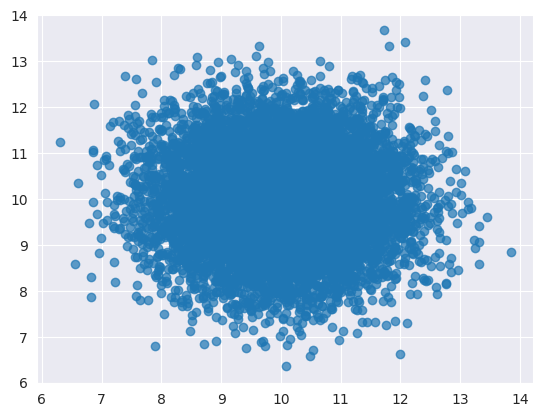

In [7]:
plt.scatter(data[:,0], data[:,1], alpha=0.7)
#plt.hist(data, bins=50, density=True)
plt.show()

## Langevin Dynamics (ULA)

In [8]:
from mcmc import ULASampler

In [9]:
rng, key = jax.random.split(rng)
sampler = ULASampler(grad_log_p=grad_log_p, dim=DIST_DIM, n_samples=500, gamma=1e-1, burnin_steps=100)
samples = sampler(key, n_chains=N_CHAINS, init_std=INIT_STD)

False


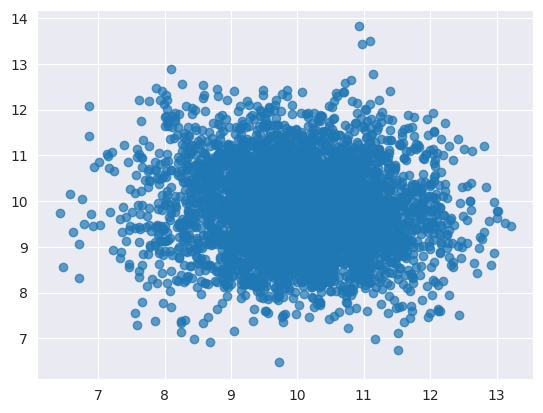

In [10]:
plt.scatter(samples[:,0], samples[:,1], alpha=0.7)
print(jnp.any(np.isnan(samples)))
#plt.hist(samples, bins=50, density=True)
plt.show()

## Baseline
Using a sample mean as an integral estimate

In [ ]:
from mcmc import estimate_n_mcmc

In [ ]:
fn = jax.jit(lambda x: x.sum(axis=-1))
true_pi = jnp.dot(mixture.coeffs, mixture.means).sum()

true_pi

Array(20., dtype=float32)

  0%|          | 0/1000 [00:00<?, ?it/s]

False


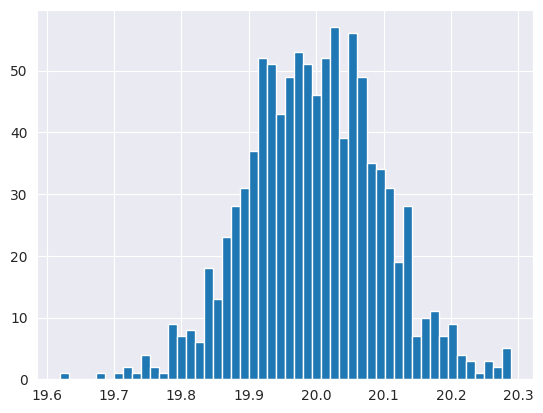

In [ ]:
rng, key = jax.random.split(rng)
baseline_estimates = estimate_n_mcmc(fn, sampler, key, init_std=INIT_STD, n_chains=N_CHAINS, n_runs=MCMC_N_RUNS)

print(jnp.any(jnp.isnan(baseline_estimates)))
plt.hist(baseline_estimates, bins=50)
plt.show()

In [ ]:
exp_results["mcmc"] = baseline_estimates

In [ ]:
true_pi - exp_results.mean()

mcmc    0.002922
dtype: float32

In [ ]:
exp_results.std()

mcmc    0.099155
dtype: float32

## Control variates (Eric's structural risk)
Train a NN with an objective from "Diffusion Approximations and Control Variates for MCMC"

In [ ]:
from diffcv.cv import CVLinear, CVTrainer, CVLoss
from diffcv.logger import Logger
from diffcv.cv.data import get_data_from_sampler

2024-07-30 17:45:45.841018: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 17:45:45.841048: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 17:45:45.841066: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-30 17:45:46.741272: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
def plot_log_results(logger: Logger):
    log_results = logger.to_pandas()
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    sns.lineplot(data=log_results["learning_rate"], ax=axes[0])
    sns.lineplot(data=log_results["loss"], ax=axes[1])
    fig.show()

In [ ]:
rng, key = jax.random.split(rng)
dataset, dataloader = get_data_from_sampler(BATCH_SIZE, sampler, key, n_chains=100, init_std=INIT_STD)
len(dataset)

40000

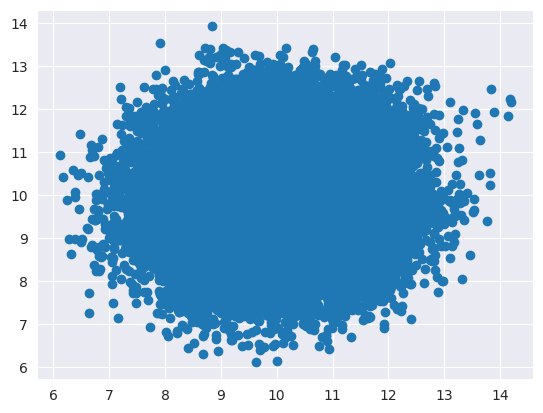

In [ ]:
plt.scatter(x=dataset.arrays[0][:, 0], y=dataset.arrays[0][:, 1])
#plt.hist(dataset.arrays[0], bins=50)
plt.show()

  0%|          | 0/15000 [00:00<?, ?it/s]

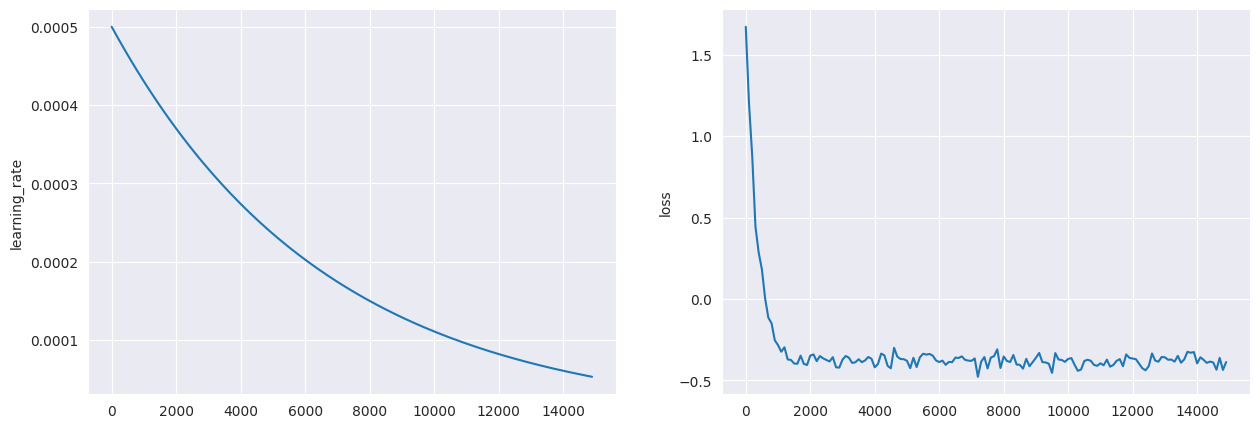

In [ ]:
rng, key = jax.random.split(rng)
cv_model = CVLinear(in_size=DIST_DIM, key=key)

scheduler = optax.exponential_decay(init_value=5e-4, transition_steps=700, decay_rate=0.9)
optimizer = optax.inject_hyperparams(optax.adam)(learning_rate=scheduler)
loss = CVLoss(fn=fn, l2_alpha=10)

logger = Logger()

cv_trainer = CVTrainer(cv_model, dataloader, optimizer, loss, logger, n_steps=15_000)

rng, key = jax.random.split(rng)
cv_trainer.train(key)

plot_log_results(logger)

In [ ]:
# Check NN for nans
rng, key = jax.random.split(rng)
x = jax.random.normal(key, shape=(100, DIST_DIM))
y = jax.vmap(cv_model)(x)
print(jnp.any(jnp.isnan(y)))

False


In [ ]:
from diffcv.cv import ScalarGenerator

In [ ]:
# Expectation of generator with respect to distribution should be 0
generator = ScalarGenerator(grad_log_p, cv_model)
jax.vmap(generator)(dataset.arrays[0][:10000]).mean()

Array(0.00848615, dtype=float32)

In [ ]:
fn_with_cv = lambda x: fn(x) + generator(x)

In [ ]:
# Check generator for nans
rng, key = jax.random.split(rng)
x = 1000 * jax.random.normal(key, shape=(100, DIST_DIM))
y = jax.vmap(generator)(x)
print(np.any(np.isnan(y)))

False


  0%|          | 0/1000 [00:00<?, ?it/s]

False


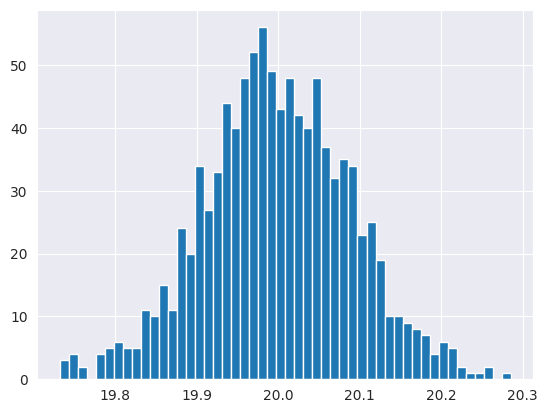

In [ ]:
rng, key = jax.random.split(rng)
cv_estimates = estimate_n_mcmc(fn_with_cv, sampler, key, init_std=INIT_STD, n_chains=N_CHAINS, n_runs=MCMC_N_RUNS)

print(jnp.any(jnp.isnan(cv_estimates)))
plt.hist(cv_estimates, bins=50)
plt.show()

In [ ]:
exp_results["diffusion_cv"] = cv_estimates

In [ ]:
true_pi - exp_results.mean()

mcmc            0.002922
diffusion_cv    0.001528
dtype: float32

In [ ]:
exp_results.std()

mcmc            0.099155
diffusion_cv    0.090778
dtype: float32

## Control variates (Diff Loss)

Use Stein equation to train NN on differences between different points

In [ ]:
rng, key = jax.random.split(rng)
dataset, dataloader = get_data_from_sampler(BATCH_SIZE, sampler, key, n_chains=100, init_std=INIT_STD)
len(dataset)

40000

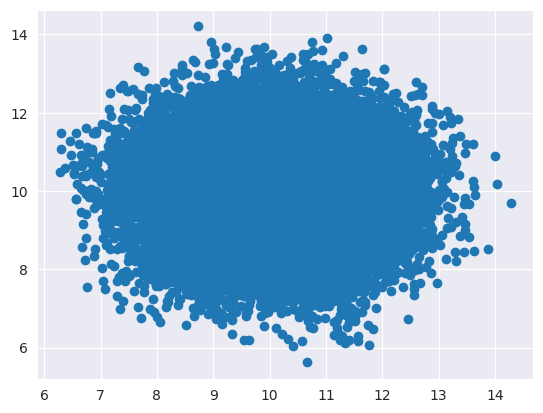

In [ ]:
plt.scatter(x=dataset.arrays[0][:, 0], y=dataset.arrays[0][:, 1])
#plt.hist(dataset.arrays[0], bins=50)
plt.show()

In [ ]:
from diffcv.cv import DiffLoss

  0%|          | 0/5000 [00:00<?, ?it/s]

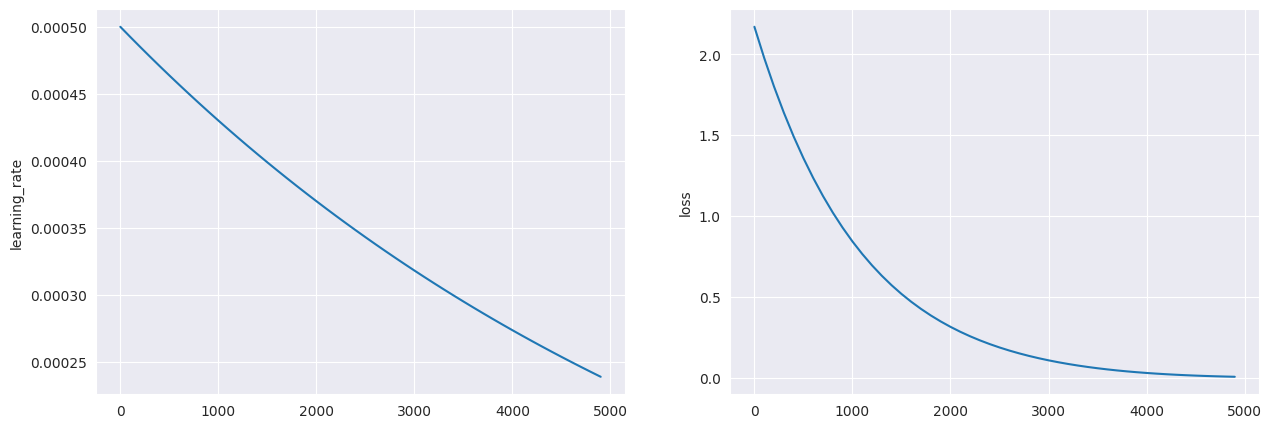

In [ ]:
rng, key = jax.random.split(rng)
cv_diff_model = CVLinear(in_size=DIST_DIM, key=key)
scheduler = optax.exponential_decay(init_value=5e-4, transition_steps=700, decay_rate=0.9)
optimizer = optax.inject_hyperparams(optax.adam)(learning_rate=scheduler)
loss = DiffLoss(fn=fn, grad_log_p=grad_log_p)

logger = Logger()

cv_diff_trainer = CVTrainer(cv_diff_model, dataloader, optimizer, loss, logger, n_steps=5_000)
rng, key = jax.random.split(rng)
cv_diff_trainer.train(key)

plot_log_results(logger)

In [ ]:
generator_diff = ScalarGenerator(grad_log_p, cv_diff_model)
jax.vmap(generator_diff)(dataset.arrays[0][:10000]).mean()

Array(-0.01512212, dtype=float32)

In [ ]:
fn_with_cv_diff = lambda x: fn(x) + generator_diff(x)

  0%|          | 0/1000 [00:00<?, ?it/s]

False


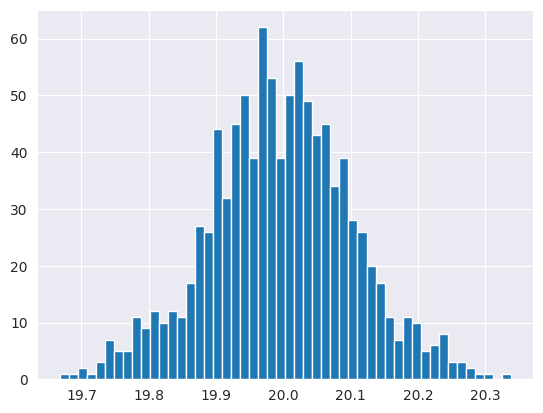

In [ ]:
rng, key = jax.random.split(rng)
cv_diff_estimates = estimate_n_mcmc(fn_with_cv_diff, sampler, key, init_std=INIT_STD, n_chains=N_CHAINS, n_runs=MCMC_N_RUNS)

print(jnp.any(jnp.isnan(cv_diff_estimates)))
plt.hist(cv_diff_estimates, bins=50)
plt.show()

In [ ]:
exp_results["diff_loss"] = cv_diff_estimates

In [ ]:
true_pi - exp_results.mean()

mcmc            0.002922
diffusion_cv    0.001528
diff_loss       0.004871
dtype: float32

In [ ]:
exp_results.std()

mcmc            0.099155
diffusion_cv    0.090778
diff_loss       0.107135
dtype: float32

## Control Variates (Var Loss)

Minimize variance of the estimator directly

In [ ]:
from diffcv.cv.loss import VarLoss

In [ ]:
rng, key = jax.random.split(rng)
dataset, dataloader = get_data_from_sampler(BATCH_SIZE, sampler, key, n_chains=100, init_std=INIT_STD)
len(dataset)

40000

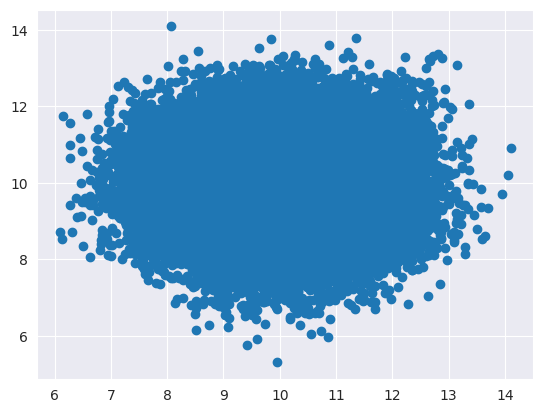

In [ ]:
plt.scatter(x=dataset.arrays[0][:, 0], y=dataset.arrays[0][:, 1])
#plt.hist(dataset.arrays[0], bins=50)
plt.show()

In [ ]:
class ModelWithConstant(eqx.Module):
    model: eqx.Module
    c: jax.Array
    
    def __init__(self, model: eqx.Module, shape, key: jax.random.PRNGKey):
        self.model = model
        self.c = jax.random.normal(key, shape)
    
    @eqx.filter_jit
    def __call__(self, x):
        return self.model(x)
    

rng, key = jax.random.split(rng)
g = CVLinear(in_size=DIST_DIM, key=key)

rng, key = jax.random.split(rng)
cv_var_model = ModelWithConstant(g, (1, ), key)

  0%|          | 0/50000 [00:00<?, ?it/s]

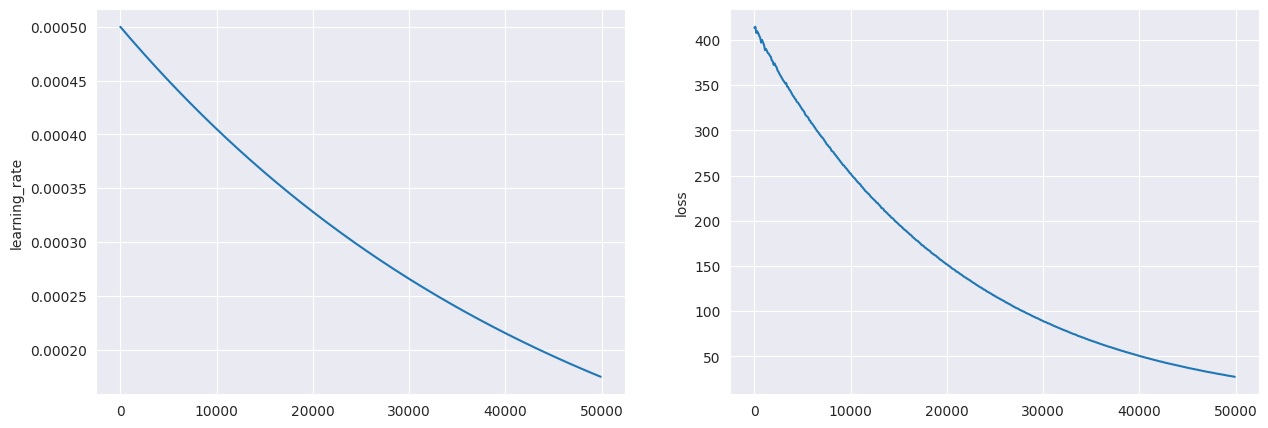

In [ ]:
scheduler = optax.exponential_decay(init_value=5e-4, transition_steps=5000, decay_rate=0.9)
optimizer = optax.inject_hyperparams(optax.adam)(learning_rate=scheduler)
loss = VarLoss(fn=fn, grad_log_p=grad_log_p)

logger = Logger()

cv_var_trainer = CVTrainer(cv_var_model, dataloader, optimizer, loss, logger, n_steps=50_000)
rng, key = jax.random.split(rng)
cv_var_trainer.train(key)

plot_log_results(logger)

In [ ]:
cv_var_model.c

Array([-0.28842148], dtype=float32)

In [ ]:
generator_var = ScalarGenerator(grad_log_p, cv_var_model.model)
jax.vmap(generator_var)(dataset.arrays[0][:10000]).mean()

Array(-0.02019123, dtype=float32)

In [ ]:
fn_with_cv_var = lambda x: fn(x) + generator_var(x)

  0%|          | 0/1000 [00:00<?, ?it/s]

False


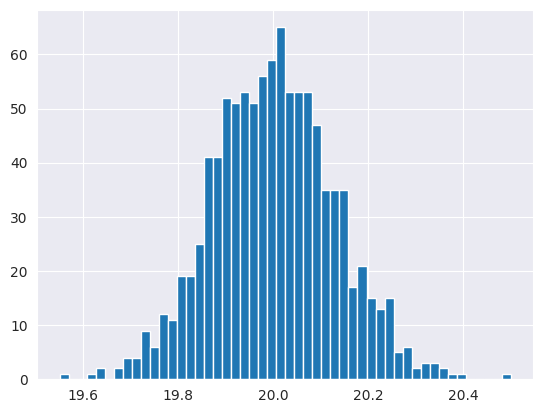

In [ ]:
rng, key = jax.random.split(rng)
cv_var_estimates = estimate_n_mcmc(fn_with_cv_var, sampler, key, init_std=INIT_STD, n_chains=N_CHAINS, n_runs=MCMC_N_RUNS)

print(jnp.any(jnp.isnan(cv_var_estimates)))
plt.hist(cv_var_estimates, bins=50)
plt.show()

In [ ]:
exp_results["var_loss"] = cv_var_estimates

In [ ]:
true_pi - exp_results.mean()

mcmc            0.002922
diffusion_cv    0.001528
diff_loss       0.004871
var_loss       -0.000973
dtype: float32

In [ ]:
exp_results.std()

mcmc            0.099155
diffusion_cv    0.090778
diff_loss       0.107135
var_loss        0.128884
dtype: float32

## Approximate gradient with NN

In [ ]:
from diffcv.cv import CVMLP
from diffcv.cv import VectorGenerator

In [ ]:
rng, key = jax.random.split(rng)
dataset, dataloader = get_data_from_sampler(BATCH_SIZE, sampler, key, n_chains=100, init_std=INIT_STD)
len(dataset)

40000

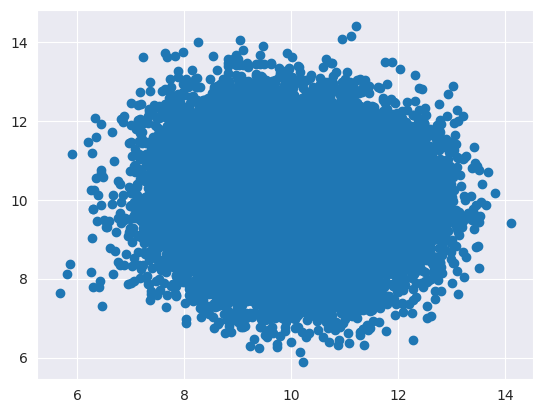

In [ ]:
plt.scatter(x=dataset.arrays[0][:, 0], y=dataset.arrays[0][:, 1])
#plt.hist(dataset.arrays[0], bins=50)
plt.show()

  0%|          | 0/5000 [00:00<?, ?it/s]

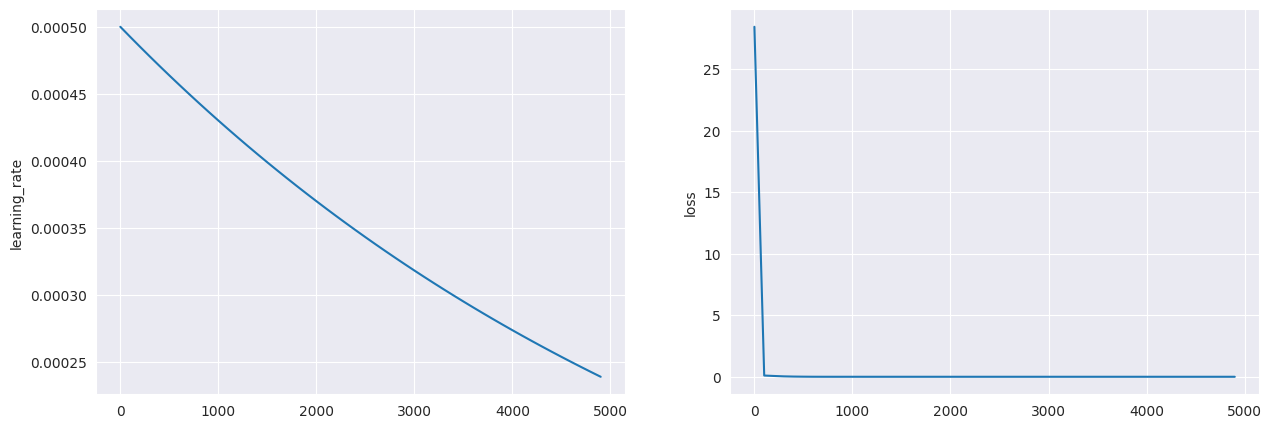

In [ ]:
rng, key = jax.random.split(rng)
cv_diff_v_model = CVMLP(in_size=DIST_DIM, out_size=DIST_DIM, width_size=64, depth=1, key=key)
scheduler = optax.exponential_decay(init_value=5e-4, transition_steps=700, decay_rate=0.9)
optimizer = optax.inject_hyperparams(optax.adam)(learning_rate=scheduler)
loss = DiffLoss(fn=fn, grad_log_p=grad_log_p, generator_cls=VectorGenerator)

logger = Logger()

cv_diff_v_trainer = CVTrainer(cv_diff_v_model, dataloader, optimizer, loss, logger, n_steps=5_000)
rng, key = jax.random.split(rng)
cv_diff_v_trainer.train(key)

plot_log_results(logger)

In [ ]:
generator_diff_v = VectorGenerator(grad_log_p, cv_diff_v_model)
jax.vmap(generator_diff_v)(dataset.arrays[0][:10000]).mean()

Array(-0.1282709, dtype=float32)

In [ ]:
fn_with_cv_diff_v = lambda x: fn(x) + generator_diff_v(x)

  0%|          | 0/1000 [00:00<?, ?it/s]

False


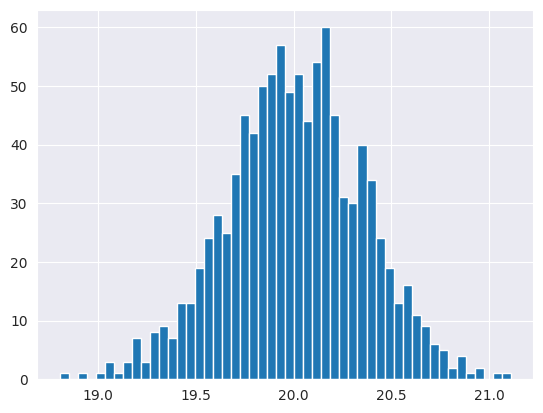

In [ ]:
rng, key = jax.random.split(rng)
cv_diff_v_estimates = estimate_n_mcmc(fn_with_cv_diff_v, sampler, key, init_std=INIT_STD, n_chains=N_CHAINS, n_runs=MCMC_N_RUNS)

print(jnp.any(jnp.isnan(cv_diff_v_estimates)))
plt.hist(cv_diff_v_estimates, bins=50)
plt.show()

In [ ]:
exp_results["diff_loss_v"] = cv_diff_v_estimates

In [ ]:
true_pi - exp_results.mean()

mcmc            0.002922
diffusion_cv    0.001528
diff_loss       0.004871
var_loss       -0.000973
diff_loss_v    -0.006559
dtype: float32

In [ ]:
exp_results.std()

mcmc            0.099155
diffusion_cv    0.090778
diff_loss       0.107135
var_loss        0.128884
diff_loss_v     0.348706
dtype: float32

## HMC

In [11]:
from diffcv.mcmc import HMCSampler

In [22]:
rng, key = jax.random.split(rng)
sampler = HMCSampler(log_p=mixture.log_p, dim=DIST_DIM, n_samples=500, gamma=1e-1, burnin_steps=100)
samples = sampler(key, n_chains=1, init_std=INIT_STD)

/home/korolevki/mcmc-control-variates/diffcv/mcmc/pyro.py:34: UserWarning: If both `num_steps` and `trajectory_length` are specified step size can't be adapted
  kernel = HMC(


AssertionError: x.shape=(1, 1, 2) != self.means.shape[1:]=(2,)